<a href="https://colab.research.google.com/github/Agbeli/Genetic_engineering_sequence/blob/main/Genetic_engineering_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "/content/drive/My Drive/Genetic_engineering_project"

/content/drive/.shortcut-targets-by-id/1fRQiQ4vPDq3WW-oCXm5kwFbSGPbNpjl9/Genetic_engineering_project


In [3]:
!pip install --upgrade torch
!pip install --upgrade skorch

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.7.0+cu101)
Requirement already up-to-date: skorch in /usr/local/lib/python3.6/dist-packages (0.9.0)


In [4]:
#### import the libraries required for implementation. 
import torch 
from torch import nn 
import sklearn 
import pandas as pd 
import numpy as np 
import skimage
import skorch 
import os 
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
import warnings 
warnings.filterwarnings("ignore")

In [5]:
%ls -sh

total 802M
165K Genetic_engineering_project.ipynb  317M train_labels.csv
 95M submission_format_3TFRxH6.csv      301M train_values.csv
 91M test_values.csv


### Import the dataset for analysis... 

In [6]:
## import the dataset into our environment 
trains_set = pd.read_csv("train_values.csv",index_col='sequence_id')
test_set = pd.read_csv("test_values.csv",index_col='sequence_id')
train_labels = pd.read_csv("train_labels.csv",index_col='sequence_id')

In [7]:
print("Shape of the trainset: ",trains_set.shape)
print("Shape of the testset: ",test_set.shape)
print("Shape of the train_labels: ", train_labels.shape)

Shape of the trainset:  (63017, 40)
Shape of the testset:  (18816, 40)
Shape of the train_labels:  (63017, 1314)


In [8]:
trains_set.dtypes

sequence                                 object
bacterial_resistance_ampicillin         float64
bacterial_resistance_chloramphenicol    float64
bacterial_resistance_kanamycin          float64
bacterial_resistance_other              float64
bacterial_resistance_spectinomycin      float64
copy_number_high_copy                   float64
copy_number_low_copy                    float64
copy_number_unknown                     float64
growth_strain_ccdb_survival             float64
growth_strain_dh10b                     float64
growth_strain_dh5alpha                  float64
growth_strain_neb_stable                float64
growth_strain_other                     float64
growth_strain_stbl3                     float64
growth_strain_top10                     float64
growth_strain_xl1_blue                  float64
growth_temp_30                          float64
growth_temp_37                          float64
growth_temp_other                       float64
selectable_markers_blasticidin          

In [9]:
### Visualize the head of the dataset
trains_set.head()

,sequence,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,copy_number_low_copy,copy_number_unknown,growth_strain_ccdb_survival,growth_strain_dh10b,growth_strain_dh5alpha,growth_strain_neb_stable,growth_strain_other,growth_strain_stbl3,growth_strain_top10,growth_strain_xl1_blue,growth_temp_30,growth_temp_37,growth_temp_other,selectable_markers_blasticidin,selectable_markers_his3,selectable_markers_hygromycin,selectable_markers_leu2,selectable_markers_neomycin,selectable_markers_other,selectable_markers_puromycin,selectable_markers_trp1,selectable_markers_ura3,selectable_markers_zeocin,species_budding_yeast,species_fly,species_human,species_mouse,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish
sequence_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9ZIMC,CATGCATTAGTTATTAATAGTAATCAATTACGGGGTCATTAGTTCA...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5SAQC,GCTGGATGGTTTGGGACATGTGCAGCCCCGTCTCTGTATGGAGTGA...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
E7QRO,NNCCGGGCTGTAGCTACACAGGGCGGAGATGAGAGCCCTACGAAAG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
CT5FP,GCGGAGATGAAGAGCCCTACGAAAGCTGAGCCTGCGACTCCCGCAG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7PTD8,CGCGCATTACTTCACATGGTCCTCAAGGGTAACATGAAAGTGATCC...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
### Description of the sequence column 
trains_set.sequence.apply(len).describe()

count    63017.000000
mean      4839.025501
std       3883.148431
min         20.000000
25%        909.000000
50%       4741.000000
75%       7490.000000
max      60099.000000
Name: sequence, dtype: float64

In [11]:
from matplotlib import pyplot as plt 
import seaborn as sns 
%matplotlib inline
sns.set()
def analyse_seq(df):
  df = df.copy()
  df.sequence.apply(len).plot(kind="hist",
                                    title= "Distribution of sequence length",
                                    bins=100,
                                    xlim=(0,20000)) 
  plt.show()

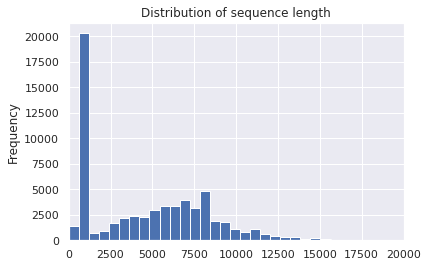

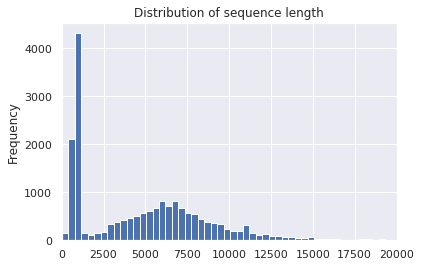

In [13]:
for df in [trains_set,test_set]:
  analyse_seq(df)

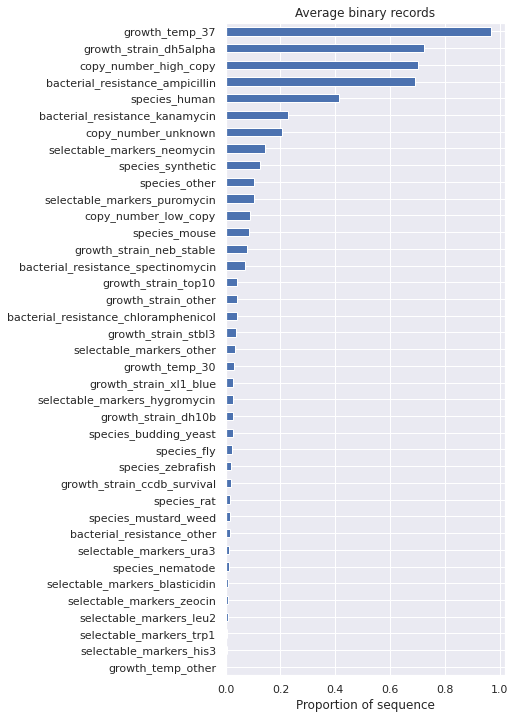

In [12]:
### Binary feature description of the dataset. 
binary_features_sorted = trains_set.iloc[:,1:].mean().sort_values()
ax = binary_features_sorted.plot(kind="barh",
                                 stacked=True,
                                 figsize = (5,12),
                                 title ="Average binary records")
ax.set_xlabel("Proportion of sequence")
plt.show()

In [14]:
### for the test case
test_set.sequence.apply(len).describe()

count    18816.000000
mean      4875.523810
std       4004.117614
min         19.000000
25%        894.750000
50%       4732.000000
75%       7341.250000
max      38638.000000
Name: sequence, dtype: float64

In [15]:
### create dataframe for the label id
label_id = pd.DataFrame(train_labels.idxmax(axis=1),columns=["Lab_id"])
label_id.head()

,Lab_id
sequence_id,
9ZIMC,RYUA3GVO
5SAQC,RYUA3GVO
E7QRO,RYUA3GVO
CT5FP,RYUA3GVO
7PTD8,RYUA3GVO


In [16]:
### multiple label scenario of each row in the dataset
label_id.shape

(63017, 1)

<h1> <center> Preprocessing of the Data </center></h1>

- First,have to implement a Kmers algorithm to have uniform vector of sequence. 

In [9]:
## Kmers algorithm 
def getKmers(sequence, size):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]
  
def preprocess_sequence(df,column):

  df = df.copy()
  x_ = []
  for row in df[column]:
    x_.append(" ".join(getKmers(row,size=6)))
  return x_

In [10]:
### access the concatenated sequence. 
x_train = preprocess_sequence(df= trains_set,column="sequence")
x_test = preprocess_sequence(df = test_set,column="sequence")

### Tranformation of the sequence dataset. 

In [11]:
cv = CountVectorizer()
cv.fit(x_train)
X_train  = cv.transform(x_train).toarray()
X_test = cv.transform(x_test).toarray()

In [20]:
X_train.shape , X_test.shape

((63017, 15532), (18816, 15532))

In [33]:
del X_train , X_test

In [25]:
# from sklearn.preprocessing import StandardScaler
# sca = StandardScaler()
# sca.fit(trains_set.iloc[:,1:].values)
# rest_trainset = sca.transform(trains_set.iloc[:,1:].values)
# rest_testset = sca.transform(test_set.iloc[:,1:].values)
# combine_trainset = np.concatenate([X_train,rest_trainset],axis=1)
# combine_testset = np.concatenate([X_test,rest_testset],axis=1)

In [12]:
from sklearn.model_selection import train_test_split
xtrainset , xtestset, ytrain , ytest = train_test_split(X_train,train_labels.values,random_state=100,test_size=25)

In [13]:
xtrainset.shape , xtestset.shape , ytrain.shape ,ytest.shape 

((62992, 15532), (25, 15532), (62992, 1314), (25, 1314))

### Modeling phase 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

model = RandomForestClassifier(random_state=100)
model.fit(xtrainset,ytrain)